Atividade 7: Inferência de Linguagem Natural

Alice da Silva de Lima

In [17]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Embedding,Activation,SimpleRNN,BatchNormalization,RNN,Flatten,Input,LSTM,Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping
from keras.datasets import reuters
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import gensim
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Activation,Embedding,SimpleRNN,Dropout
from keras.utils.np_utils import to_categorical

In [19]:
ds_train = tfds.load('snli', split='train[50%:]', shuffle_files=True)
ds_valid = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)

In [4]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [5]:
def transform_data(df):
  premise_hypothesis = []

  for index, row in df.iterrows():
    new_row = df['premise'][index].decode("utf-8") + ' ' + df['hypothesis'][index].decode("utf-8")
    premise_hypothesis.append(new_row)


  l = [df["label"]]
  headers = ["label"]
  n_df = pd.concat(l, axis=1, keys=headers)
  n_df["premise_hypothesis"] = premise_hypothesis

  return n_df

In [6]:
df_train = transform_data(df_train)
df_valid = transform_data(df_valid)
df_test = transform_data(df_test)

In [7]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [8]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [9]:
train_sentences = df_train['premise_hypothesis'].to_list()

In [10]:
vocab = {}

for i in range(0,len(train_sentences)):
    train_sentences[i] = train_sentences[i].lower()
    for word in train_sentences[i].split():
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word]+=1

vocab_size = len(vocab)

In [11]:
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(df_train['premise_hypothesis'])

In [12]:
train_sequences = tokenizer.texts_to_sequences(df_train['premise_hypothesis'])
valid_sequences = tokenizer.texts_to_sequences(df_valid['premise_hypothesis'])
test_sequences = tokenizer.texts_to_sequences(df_test['premise_hypothesis'])

Padding

In [13]:
trunc_type = 'post'
padding_type = 'post'
max_length = 64

In [14]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#Modelos

##RNN

In [15]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_length))
model.add(SimpleRNN(128,return_sequences=True,activation='relu'))
model.add(Dropout(0.5))
model.add(SimpleRNN(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 64)            2908864   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64, 128)           24704     
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 2,946,180
Trainable params: 2,946,180
Non-

In [20]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.2 MB/s 


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)

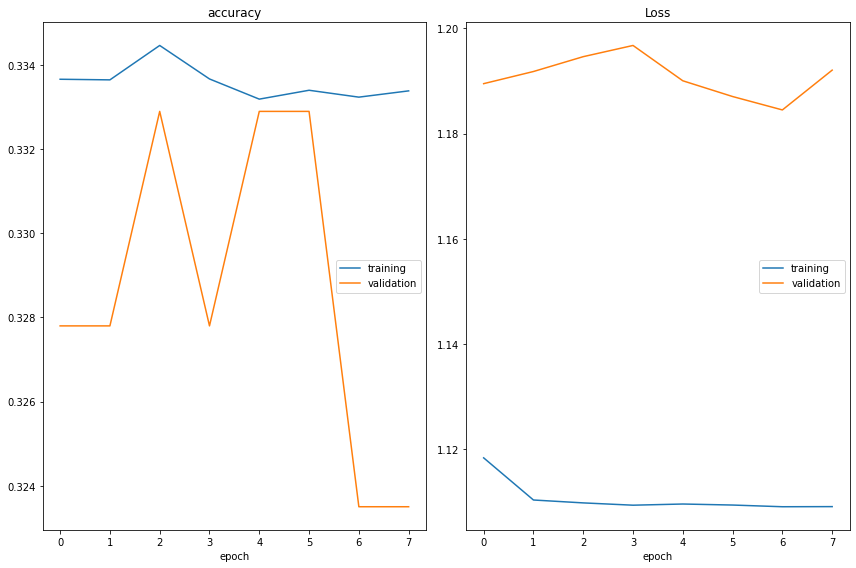

accuracy
	training         	 (min:    0.333, max:    0.334, cur:    0.333)
	validation       	 (min:    0.324, max:    0.333, cur:    0.324)
Loss
	training         	 (min:    1.109, max:    1.118, cur:    1.109)
	validation       	 (min:    1.185, max:    1.197, cur:    1.192)
8597/8597 [==============================] - 943s 110ms/step - loss: 1.1090 - accuracy: 0.3334 - val_loss: 1.1921 - val_accuracy: 0.3235


In [19]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=10, batch_size=32, callbacks = [PlotLossesCallback(), early_stopping])

In [20]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.00      0.00      0.00      3368
           2       0.32      1.00      0.49      3219
           3       0.00      0.00      0.00      3237

    accuracy                           0.32     10000
   macro avg       0.08      0.25      0.12     10000
weighted avg       0.10      0.32      0.16     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM

In [15]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_length))
model2.add(LSTM(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation="softmax"))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 64)            2908864   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 2,942,148
Trainable params: 2,942,148
Non-trainable params: 0
_________________________________________________________________


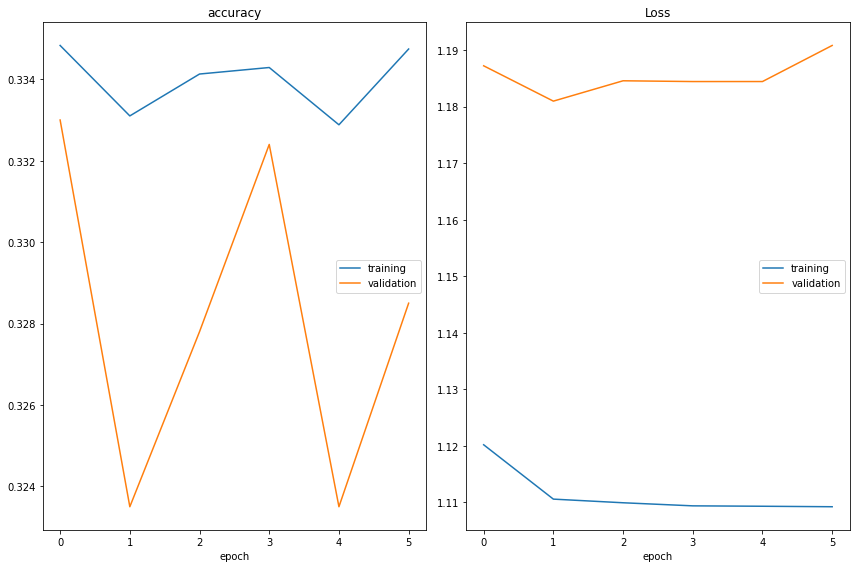

accuracy
	training         	 (min:    0.333, max:    0.335, cur:    0.335)
	validation       	 (min:    0.324, max:    0.333, cur:    0.329)
Loss
	training         	 (min:    1.109, max:    1.120, cur:    1.109)
	validation       	 (min:    1.181, max:    1.191, cur:    1.191)
8597/8597 [==============================] - 379s 44ms/step - loss: 1.1092 - accuracy: 0.3347 - val_loss: 1.1908 - val_accuracy: 0.3285


In [23]:
sgd = SGD(learning_rate=0.01)
model2.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history2 = model2.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=10, batch_size=32, callbacks = [PlotLossesCallback(), early_stopping])

In [24]:
y_prob = model2.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.00      0.00      0.00      3368
           2       0.41      0.03      0.06      3219
           3       0.33      0.98      0.49      3237

    accuracy                           0.33     10000
   macro avg       0.18      0.25      0.14     10000
weighted avg       0.24      0.33      0.18     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
